In [1]:
import numpy as np

In [2]:
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from ipywidgets import widgets

In [3]:
import torch 
import torch.nn as nn
from torch.autograd import Variable

In [4]:
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
import os
#os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
#os.environ["CUDA_VISIBLE_DEVICES"]="4"
device = torch.device("cuda")
print(device)
import matplotlib.pyplot as plt
from tqdm import tqdm

cuda


In [5]:
import matplotlib.pyplot as plt
plt.style.use('dark_background')

In [6]:
class RNN(nn.Module): 
    def __init__(self, input_dim = 93, hidden_dim = 256, output_dim = 93):
        super(RNN, self).__init__()
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.GRU = nn.GRUCell(input_dim, hidden_dim)
        self.linear = nn.Linear(hidden_dim, output_dim)
        
    def forward(self, x, output_length): 
        x = x.permute(0, 2, 1).float().to(device)
        x = x.reshape(x.shape[0] * x.shape[1], -1) 
        x = x.unsqueeze(dim = 0)

        outputs = torch.zeros((1, x.shape[1], output_length)).float().to(device) 
        
        hn = torch.zeros(1, self.hidden_dim).to(device)
        
        for i in range(output_length):
            rnnInput = x[0, :, i].unsqueeze(dim = 0)
            hn = self.GRU(rnnInput, hn) 
            output = self.linear(hn)
            outputs[:, :, i] = output
            rnnInput = output 
        
        outputs = outputs.squeeze()
        outputs = outputs.reshape(3, 31, output_length) 
        outputs = outputs.permute(0, 2, 1)
        
        return outputs

In [11]:
class ResRNN(nn.Module):

    def __init__(self, input_dim, hidden_dim, output_dim, resDepth):
        super(ResRNN, self).__init__()
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.output_dim = output_dim
        self.resDepth = resDepth
        
        self.i2h = nn.Linear(self.input_dim, self.hidden_dim, bias=True)
        self.h2h = nn.Linear(self.hidden_dim, self.hidden_dim, bias=True)
        self.h2o = nn.Linear(self.hidden_dim, self.output_dim, bias=True)
        self.linear = nn.Linear(self.hidden_dim, self.output_dim, bias=True)
        # self.ht2h = nn.Linear(self.hiddenNum, self.hiddenNum, bias=True)
        self.tanh = nn.Tanh()

    def forward(self, x, output_length):
        x = x.permute(0, 2, 1).float().to(device)
        x = x.reshape(x.shape[0] * x.shape[1], -1) 
        x = x.unsqueeze(dim = 0)

        h0 = Variable(torch.zeros(1, self.hidden_dim).to(device))
        ht = h0

        outputs = []

        for i in range(output_length):
            hn = self.i2h(x[0, :, i]) + self.h2h(h0)

            if i == 0:
                hstart = hn
            elif i == output_length - 2:
                h0 = self.tanh(hn + hstart)
            else:
                if self.resDepth == 1:
                    h0 = self.tanh(hn + h0)
                else:
                    if i % self.resDepth == 0:
                        h0 = self.tanh(hn + ht)
                        ht = hn
                    else:
                        h0 = self.tanh(hn)
            outputs.append(self.linear(hn))

        output = torch.cat(outputs, 0) 
#         output = self.linear(hidden)
        output = output.permute(1, 0)
#         print(output.shape)
        output = output.reshape(3, 31, output_length) 
        output = output.permute(0, 2, 1)
        
        return output

In [59]:
class ResLSTMCell(nn.Module):
    def __init__(self, input_size, hidden_size, output_dim, dropout=0.):
        super(ResLSTMCell, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_dim = output_dim
        self.weight_ii = nn.Parameter(torch.randn(3 * hidden_size, input_size))
        self.weight_ic = nn.Parameter(torch.randn(3 * hidden_size, hidden_size))
        self.weight_ih = nn.Parameter(torch.randn(3 * hidden_size, hidden_size))
        self.bias_ii = nn.Parameter(torch.randn(3 * hidden_size))
        self.bias_ic = nn.Parameter(torch.randn(3 * hidden_size))
        self.bias_ih = nn.Parameter(torch.randn(3 * hidden_size))
        self.weight_hh = nn.Parameter(torch.randn(1 * hidden_size, hidden_size))
        self.bias_hh = nn.Parameter(torch.randn(1 * hidden_size))
        self.weight_ir = nn.Parameter(torch.randn(hidden_size, input_size))
        #self.dropout_layer = nn.Dropout(dropout)
        self.dropout = dropout

#     @jit.script_method
    def forward(self, x, hidden):
        # type: (Tensor, Tuple[Tensor, Tensor]) -> Tuple[Tensor, Tuple[Tensor, Tensor]]
        hx, cx = hidden[0], hidden[1]
        x = x.unsqueeze(0)
#         print(hx.shape)
#         print(x.shape)
#         print(self.weight_ii.shape)
#         print((torch.mm(x, self.weight_ii.t()) + self.bias_ii).shape)
        ifo_gates = (torch.mm(x, self.weight_ii.t()) + self.bias_ii +
                     torch.mm(hx, self.weight_ih.t()) + self.bias_ih +
                     torch.mm(cx, self.weight_ic.t()) + self.bias_ic)
        ingate, forgetgate, outgate = ifo_gates.chunk(3, 1)
        
        cellgate = torch.mm(hx, self.weight_hh.t()) + self.bias_hh
        
        ingate = torch.sigmoid(ingate)
        forgetgate = torch.sigmoid(forgetgate)
        cellgate = torch.tanh(cellgate)
        outgate = torch.sigmoid(outgate)

        cy = (forgetgate * cx) + (ingate * cellgate)
        ry = torch.tanh(cy)

        if self.input_size == self.hidden_size:
            hy = outgate * (ry + x)
        else:
            hy = outgate * (ry + torch.mm(x, self.weight_ir.t()))
        return hy, (hy, cy)

class ResLSTM(nn.Module):
    def __init__(self, input_size, hidden_dim, output_dim, dropout=0.):
        super(ResLSTM, self).__init__()
        self.input_size = input_size
        self.hidden_dim = hidden_dim
        #self.cell = LSTMCell(input_size, hidden_size, dropout=0.)
        self.cell = ResLSTMCell(input_size, hidden_dim, output_dim, dropout=0.)
        self.linear = nn.Linear(hidden_dim, output_dim)

#     @jit.script_method
    def forward(self, x, output_length):
        x = x.permute(0, 2, 1).float().to(device)
        x = x.reshape(x.shape[0] * x.shape[1], -1) 
        x = x.unsqueeze(dim = 0) 
        h_0 = torch.zeros(1, self.hidden_dim).to(device)
        c_0 = torch.zeros(1, self.hidden_dim).to(device)
        hidden = (h_0,c_0)

        outputs = []
#         for i in range(len(inputs)):
#             out, hidden = self.cell(inputs[i], hidden)
#             outputs += [out]
#         outputs = torch.stack(outputs)
#         rnnInput = x[0, :, 0]
        for i in range(output_length):
            output, hidden = self.cell(x[0, :, i], hidden)
            output = self.linear(output).squeeze(0)
            outputs.append(output)
#             rnnInput = output

        outputs = torch.cat(outputs, 0) 
#         outputs = self.linear(outputs)
#         print("outputs.size()", outputs.size()) 
        outputs = outputs.reshape(3, 31, output_length) 
        outputs = outputs.permute(0, 2, 1)
        return outputs

In [7]:
y_exact=torch.load("5S_191111_3cmp_torch.pt")
#first row (0) k, then (1) q, then (2) u
#y_exact=y_exact[0:5,:]
print(y_exact.shape)

torch.Size([3, 71, 31])


### Normalization 

In [8]:
# min-max normalization for k and u 
y_min = torch.tensor([y_exact[0, :, :].min(), y_exact[1, :, :].min(), y_exact[2, :, :].min()])
y_max = torch.tensor([y_exact[0, :, :].max(), y_exact[1, :, :].max(), y_exact[2, :, :].max()])
y_norm = torch.zeros(y_exact.shape, dtype = torch.float).to(device)
y_norm[0, :, :] = (y_exact[0, :, :] - y_min[0]) / (y_max[0] - y_min[0]) 
y_norm[1, :, :] = (y_exact[1, :, :] - y_min[1]) / (y_max[1] - y_min[1]) 
# y_norm[1, :, :] = y_exact[1, :, :]
y_norm[2, :, :] = (y_exact[2, :, :] - y_min[2]) / (y_max[2] - y_min[2]) 

In [12]:
input_dim = 93
hidden_dim = 256
output_dim = 93
resDepth = 10

resRNN = ResRNN(input_dim, hidden_dim, output_dim, resDepth).to(device)
# resRNN = ResLSTM(input_dim, hidden_dim, output_dim, 0).to(device)

In [13]:
#torch.optim.lr_scheduler.StepLR?
#torch.optim.SGD?

In [14]:
optimizer = torch.optim.Adam(resRNN.parameters(), lr=0.01)
#optimizer = torch.optim.SGD(tdnu.parameters(), lr=0.001)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=0.95) #0.95 #step_size=1
#torch.optim.lr_scheduler.StepLR?

- reduce time step $\Delta t$
- try different optimizer
- reduce learning rate decay (step_size in scheduler) - 500 epochs

In [15]:
num_epochs = 100
loss_fun = torch.nn.MSELoss()
min_loss = 10

In [16]:
y_approx = resRNN(y_norm[:, 0:68], 68)
print(y_norm[:, 1:69].shape, y_approx.shape)

torch.Size([3, 68, 31]) torch.Size([3, 68, 31])


In [17]:
print(y_approx.shape, y_norm.shape)
loss=loss_fun(y_approx, y_norm[:, 1:69, :])
#torch.cat(tdn.k, dim=1).shape
#torch.cat([torch.tensor(p) for p in tdn.k], dim=1).shape
print("Initial loss: %e" % loss)
loss_history=[loss.item()]

torch.Size([3, 68, 31]) torch.Size([3, 71, 31])
Initial loss: 3.977939e-01


In [18]:
## loss without normalization 
y_approx_actual = torch.zeros(y_approx.shape) 
y_approx_actual[0, :, :] = y_approx[0, :, :] * (y_max[0] - y_min[0]) + y_min[0]
y_approx_actual[1, :, :] = y_approx[1, :, :] * (y_max[1] - y_min[1]) + y_min[1]
y_approx_actual[2, :, :] = y_approx[2, :, :] * (y_max[2] - y_min[2]) + y_min[2] 

loss=loss_fun(y_approx_actual, y_exact[:, 1:69, :]) 
print("Initial actual loss: %e" % loss)

Initial actual loss: 5.007978e+01


In [19]:
history=[]
tqdm_epochs = tqdm(range(num_epochs))
for e in tqdm_epochs:
    y_approx = resRNN(y_norm[:, 0:68], 68)
    loss = loss_fun(y_approx, y_norm[:, 1:69, :])
    loss_history.append(loss.item())
    if loss.item() < min_loss:
        best_model_resRNN = resRNN
    optimizer.zero_grad()
    loss.backward(retain_graph=True)
    optimizer.step()
    history.append(loss.item())
    tqdm_epochs.set_postfix({'loss': torch.sum(loss).item()}) 
    
    scheduler.step() 

100%|██████████| 100/100 [00:02<00:00, 35.15it/s, loss=0.00913]


In [20]:
## loss without normalization 
y_approx_actual = torch.zeros(y_approx.shape) 
y_approx_actual[0, :, :] = y_approx[0, :, :] * (y_max[0] - y_min[0]) + y_min[0]
y_approx_actual[1, :, :] = y_approx[1, :, :] * (y_max[1] - y_min[1]) + y_min[1]
y_approx_actual[2, :, :] = y_approx[2, :, :] * (y_max[2] - y_min[2]) + y_min[2] 

loss=loss_fun(y_approx_actual, y_exact[:, 1:69, :]) 
print("Initial actual loss: %e" % loss)

Initial actual loss: 8.903962e-01


In [21]:
xi = [0, 4, 12, 22, 32, 39, 46, 50, 54, 57, 59, 63, 66, 69, 71, 74, 76, 81, 84, 86, 89, 91, 95, 96, 98, 100, 102, 105, 108, 110, 112]

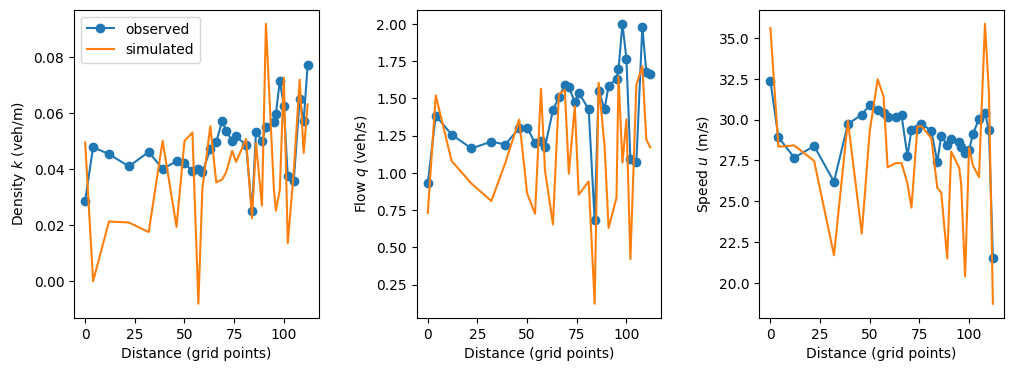

In [22]:
tp=1
#print(y_approx[tp])
#print(y_exact[tp])
plt.style.use('default')
fig3,ax3=plt.subplots(ncols=3, nrows=1, figsize=(12,4))
fig3.subplots_adjust(wspace=0.4)

varplot={0: y_approx_actual[0, :, :], 1: y_approx_actual[1, :, :], 2: y_approx_actual[2, :, :]}
label={0: "Density $k$ (veh/m)",
       1: "Flow $q$ (veh/s)",
       2: "Speed $u$ (m/s)"}
for n in range(3):
    ax3[n].plot(xi, y_exact[n,1,:].detach(), label='observed', marker='o')
    if n==1: 
        ax3[n].plot(xi, varplot[n][0].detach(), label='simulated') 
    else: 
        ax3[n].plot(xi, varplot[n][0].detach(), label='simulated')
    #print(k_boundary[tp*tskip])
    if n==0:
        ax3[n].legend()
    ax3[n].set_xlabel("Distance (grid points)")
    ax3[n].set_ylabel(label[n])
#ax3.set_ylim(0, 0.3)
fig3.savefig("kqu_parstep10.png", dpi=300)

In [23]:
y_predicted = resRNN(y_norm[:, 67:, :], 3).detach()

In [24]:
## re-transform: testing loss without normalization (used for comparison)
y_predicted_actual = torch.zeros(y_predicted.shape) 
y_predicted_actual[0, :, :] = y_predicted[0, :, :] * (y_max[0] - y_min[0]) + y_min[0]
y_predicted_actual[1, :, :] = y_predicted[1, :, :] * (y_max[1] - y_min[1]) + y_min[1]
y_predicted_actual[2, :, :] = y_predicted[2, :, :] * (y_max[2] - y_min[2]) + y_min[2] 

loss=loss_fun(y_predicted_actual, y_exact[:, 68:, :]) 
print("Final actual loss: %e" % loss) 

Final actual loss: 6.611192e+00


In [34]:
1.100848e+00

1.100848

In [35]:
y_predicted.shape

torch.Size([3, 3, 31])

In [87]:
import json

station_names=list(json.load(open("5S_station_names.json", "rb")).values())
record_times=json.load(open("5S_record_times.json", "r"))
#record_times

FileNotFoundError: [Errno 2] No such file or directory: '5S_record_times.json'

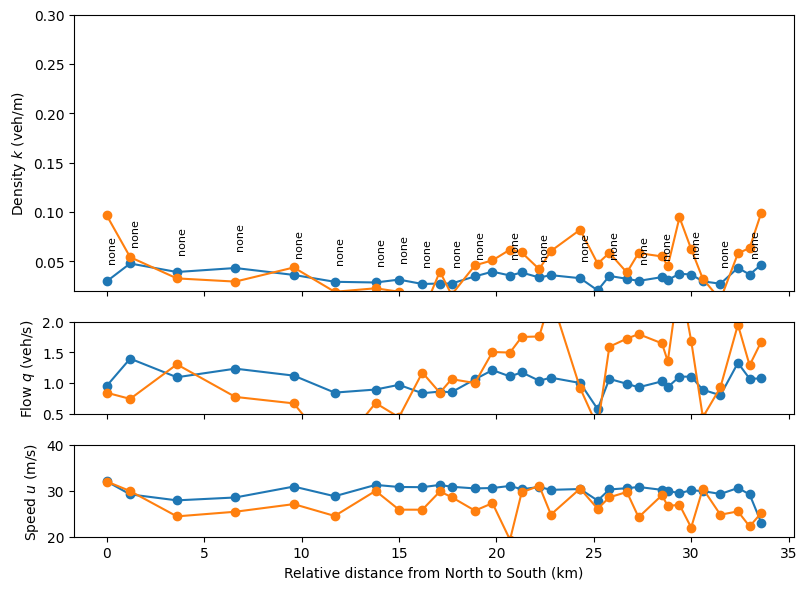

In [26]:
tp=70
plt.style.use('default')

from matplotlib import gridspec

fwyp=[xi[n]* 300 / 1.e3 for n in range(len(xi))]

#gs = gridspec.GridSpec(3, 1, height_ratios=[2, 1, 1]) 
gs_kw={"height_ratios": [3, 1, 1]}

fig4,ax4=plt.subplots(figsize=(8,6), nrows=3, gridspec_kw=gs_kw, sharex=True)
fig4.subplots_adjust(left=0.08, bottom=0.08, right=0.98, top=0.95)
ymin=[0.02, 0.5, 20]
ymax=[0.30, 2.0, 40]

for n in range(3): 
    ax4[n].plot(fwyp, (y_norm[n, tp, :] * (y_max[n] - y_min[n]) + y_min[n]).cpu().detach(), label='observed', marker='o')
    ax4[n].plot(fwyp, (y_predicted[n, tp-68, :] * (y_max[n] - y_min[n]) + y_min[n]).cpu().detach(), label='predicted', marker='o')
        
    ax4[n].set_ylim(ymin[n], ymax[n])
    #ax4[n].set_xlabel("Distance (grid points)")
    ax4[n].set_ylabel(label[n])

    #ax4[n].set_xlim(fwyp[0]-1, fwyp[-1]+1)

    lastpoint=-100
    if n==0:
        for p in range(len(xi)):
            if (fwyp[p] - lastpoint) > 1.:
                ax4[n].text(fwyp[p], (y_norm[n, tp, :] * (y_max[n] - y_min[n]) + y_min[n]).detach()[p] + 0.02, "none", rotation=90, fontsize=8)
                lastpoint=fwyp[p]
    
ax4[2].set_xlabel("Relative distance from North to South (km)")
#ax4[n].set_ylabel("Traffic density (Veh/m)")
fig4.savefig('LWR_prediction_5S.jpg', dpi=300)